# Info
Contact: Patrick.Jantz@nau.edu\
Purpose: Compare performance of python graph packages for cost matrix calculation.

In [1]:
# Imports
import numpy as np, math, time, pandas as pd, random
from scipy import sparse
from pylab import imshow
import networkx as nx
#import retworkx as rt
import igraph as ig
import networkit as nt
from scipy.sparse import diags
import rasterio as rio
import matplotlib.pyplot as plt

C:\Users\pj276\Anaconda3\envs\pynet\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Functions
# Minor modification from 
# https://stackoverflow.com/questions/30199070/how-to-create-a-4-or-8-connected-adjacency-matrix
# Diagonal weights set to sqrt(2). Orthogonal weights set to 1.
# Calculation for conductance is then conductance value/cellres*weight
def connected_adjacency(image, connect, patch_size=(1, 1)):
    """
    Creates an adjacency matrix from an image where nodes are considered adjacent 
    based on 4-connected or 8-connected pixel neighborhoods.
    :param image: 2 or 3 dim array
    :param connect: string, either '4' or '8'
    :param patch_size: tuple (n,m) used if the image will be decomposed into 
                   contiguous, non-overlapping patches of size n x m. The 
                   adjacency matrix will be formed from the smaller sized array
                   e.g. original image size = 256 x 256, patch_size=(8, 8), 
                   then the image under consideration is of size 32 x 32 and 
                   the adjacency matrix will be of size 
                   32**2 x 32**2 = 1024 x 1024
    :return: adjacency matrix as a sparse matrix (type=scipy.sparse.csr.csr_matrix)
    """
    r, c = image.shape[:2]
    r = int(r / patch_size[0])
    c = int(c / patch_size[1])
    if connect == '4':
        # constructed from 2 diagonals above the main diagonal
        d1 = np.tile(np.append(np.ones(c-1), [0]), r)[:-1]
        d2 = np.ones(c*(r-1))
        upper_diags = diags([d1, d2], [1, c])
        return upper_diags + upper_diags.T
    elif connect == '8':
        # constructed from 4 diagonals above the main diagonal
        d1 = np.tile(np.append(np.ones(c-1), [0]), r)[:-1]
        d2 = np.append([0], d1[:c*(r-1)])
        d3 = np.ones(c*(r-1))
        d4 = d2[1:-1]
        d4[d4==1] = 2.0**0.5
        upper_diags = diags([d1, d2, d3, d4], [1, c-1, c, c+1])
        return upper_diags + upper_diags.T
    else:
        raise ValueError('Invalid parameter \'connect\'={connect}, must be "4" or "8".'
                     .format(connect=repr(connect)))

In [4]:
# Set dirs
dataDir = 'G:/My Drive/Projects/USFSIP_Connectivity/Data/GeoData/cleo_test/'
outDir = 'G:/My Drive/Projects/USFSIP_Connectivity/Data/GeoData/cleo_test/out'

# Resistance surface path
inresist = "G:/My Drive/Projects/USFSIP_Connectivity/Data/GeoData/cleo_test/resistance/resist_base_roads.rsg"

# XYfile path
xyfilename = dataDir + '/xys/SP_base.xy'

In [6]:
# Ready xys
xys = pd.read_csv(xyfilename)

# Use dataset index method to get cell numbers for each xy
# Read dataset to array
with rio.open(inresist) as ds:   
    cinds = [ds.index(i[1].X,i[1].Y) for i in xys.iterrows()]
    sources = [(i[0]*ds.shape[1])+i[1] for i in cinds]
    A = ds.read(1)
    #A[A==-9999]=1000

In [8]:
len(sources)
np.max(sources)

650850

In [9]:
# Convert resistance surface to adjacency matrix and then to graph
tic = time.perf_counter()
adj8 = connected_adjacency(ds, '8').astype("float32").tocsr()
sinds = sparse.find(adj8)
# Calculate cost weights as average for adjacent cells
A = A.flatten()
adj8[sinds[0],sinds[1]] = ((A[sinds[0]] + A[sinds[1]])/2)*sinds[2]*500 # 500 is cell size for test data
# Convert adjacency matrix to graph
G8 = nx.from_scipy_sparse_array(adj8)
# Set node attribute using cell value
nx.set_node_attributes(G8, dict(zip(range(0,G8.number_of_nodes()), [{'value': i} for i in A])))
node_values = nx.get_node_attributes(G8, 'value')
# Remove no data nodes
G8.remove_nodes_from((n for n, w in node_values.items() if w == -9999))
toc = time.perf_counter()
print(f"The process took {toc - tic:0.4f} seconds")

The process took 10.7119 seconds


In [10]:
# Convert networkx graph to networkit graph
tic = time.perf_counter()
ntg = nt.nxadapter.nx2nk(G8, weightAttr='weight')
# Index edges
ntg.indexEdges()
toc = time.perf_counter()
print(f"The process took {toc - tic:0.4f} seconds")

The process took 1.5203 seconds


In [15]:
# Calculate costs from each occupied cell to every other cell
# Note: the new version of networkit allows target cell/node designation
tic = time.perf_counter()
# Some pairs shortest paths
# use actual sources, doesn't run now  because removing no data nodes
# from the graph messes up the indexing
#spsp = nt.distance.SPSP(ntg, sources)
 # use random sources
spsp = nt.distance.SPSP(ntg, random.sample(range(0, 290098), 100))
# Run
spsp.run()
# Get lists of distances
dists = spsp.getDistances()
toc = time.perf_counter()
print(f"The process took {toc - tic:0.4f} seconds")

The process took 1.7387 seconds


The process took 2.7447 seconds
The process took 0.9573 seconds
The process took 1.8823 seconds
The process took 8.8788 seconds
The process took 15.2575 seconds
The process took 20.8576 seconds


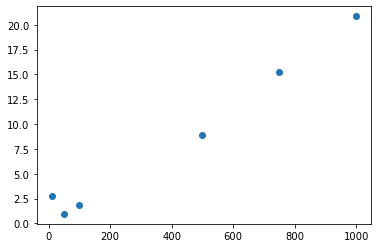

In [39]:
# NETWORKIT
# Calculate costs from random sources
# Currently calculates from each source to every cell in the resistance raster
# The new version allows target cell designation
ntTimes = []
nnodes = [10,50,100,500,750,1000]
for i in nnodes:
    snodes = random.sample(range(0, 290098), i)
    tic = time.perf_counter()
    # Some pairs shortest paths
    spsp = nt.distance.SPSP(ntg, snodes)
    # Run
    spsp.run()
    atest = spsp.getDistances()
    toc = time.perf_counter()
    print(f"The process took {toc - tic:0.4f} seconds")
    ntTimes.append(toc - tic)


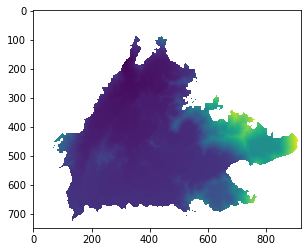

In [43]:
from pylab import imshow
dArr = np.full([A.shape[0]],-9999)
dArr.dtype = 'float32'
dArr[list(G8.nodes)] = atest[1]
imshow(dArr.reshape(749,923))

In [36]:
# IGRAPH
igg = ig.Graph.from_networkx(G8)

The process took 0.9068 seconds
The process took 3.9683 seconds
The process took 7.4757 seconds
The process took 39.2845 seconds
The process took 56.9965 seconds
The process took 76.4464 seconds


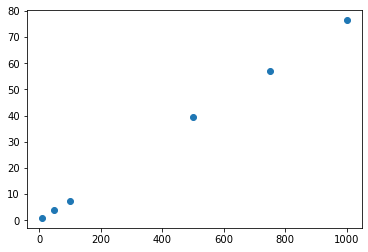

In [38]:
# Calculate costs from random sources to check scaling
igTimes = []
nnodes = [10,50,100,500,750,1000]
for i in nnodes:
    snodes = random.sample(range(0, 290098), i)
    tic = time.perf_counter()
    spsp = igg.shortest_paths(source=snodes, target=snodes, weights='weight',mode='out')
    toc = time.perf_counter()
    print(f"The process took {toc - tic:0.4f} seconds")
    igTimes.append(toc - tic)

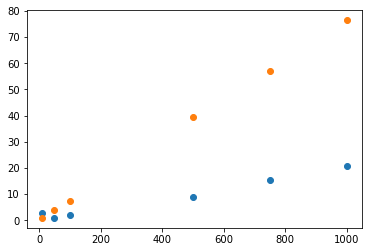

In [44]:
# Plot times
plt.scatter(nnodes,ntTimes)
plt.scatter(nnodes,igTimes)